In [2]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal 
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model

In [3]:
import pickle
pkl_file = open('drive/My Drive/Colab Notebooks/dataset/encoded_text64D_1.pkl', 'rb')
embed_X = pickle.load(pkl_file)
pkl_file = open('drive/My Drive/Colab Notebooks/dataset/encoded_text64D_2.pkl', 'rb')
embed_X2 = pickle.load(pkl_file)
embed_X=np.concatenate((embed_X,embed_X2))
pkl_file = open('drive/My Drive/Colab Notebooks/dataset/encoded_text64D_3.pkl', 'rb')
embed_X2 = pickle.load(pkl_file)
embed_X=np.concatenate((embed_X,embed_X2))
#embed_X=np.reshape(embed_X, (embed_X.shape[0],32,-1))
print(embed_X.shape)
pkl_file = open('drive/My Drive/Colab Notebooks/dataset/labels2.pkl', 'rb')
labels = pickle.load(pkl_file)
print(labels.shape)
pkl_file.close()

(91795, 200, 64)
(91795,)


In [4]:
embed_X=np.reshape(embed_X, (embed_X.shape[0],64,-1))
from sklearn.model_selection import train_test_split
trainX, testX, trainy, testy = train_test_split(embed_X, labels, test_size=0.18)

In [8]:
trainy.shape

(75271,)

In [ ]:
import keras.backend as K
from keras.layers import Conv2DTranspose, Lambda


def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='same',activation=None,name=None,kernel_initializer=None):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding,activation=activation,name=name,kernel_initializer=kernel_initializer)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 128, 200)     0                                            
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 64, 200)      120200      input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_23 (LeakyReLU)      (None, 64, 200)      0           conv1d_25[0][0]                  
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 64, 200)      120200      leaky_re_lu_23[0][0]             
____________________________________________________________________________________________

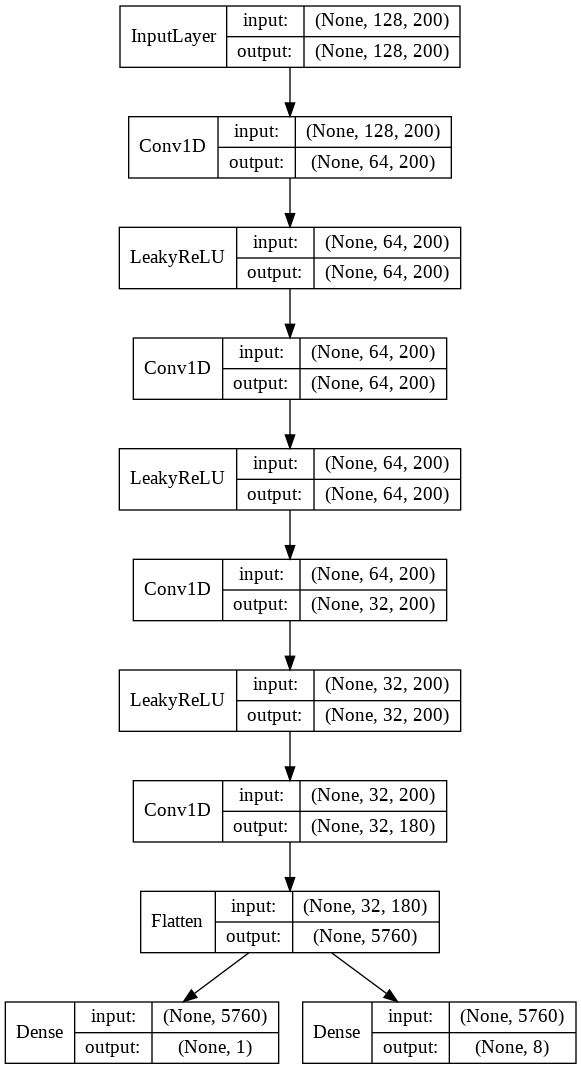

In [ ]:
# example of defining the discriminator model

# define the standalone discriminator model
def define_discriminator(in_shape=(128,200), n_classes=8):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# downsample to 14x14
	fe = Conv1D(filters=200, kernel_size=3, strides=2, padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
#	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv1D(filters=200, kernel_size=3, padding='same', kernel_initializer=init)(fe)
#	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
#	fe = Dropout(0.5)(fe)
	# downsample to 7x7
	fe = Conv1D(filters=200, kernel_size=3, strides=2, padding='same', kernel_initializer=init)(fe)
#	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
#	fe = Dropout(0.5)(fe)
	# normal
	fe = Conv1D(filters=180, kernel_size=3, padding='same', kernel_initializer=init)(fe)
#	fe = BatchNormalization()(fe)
#	fe = LeakyReLU(alpha=0.2)(fe)
#	fe = Dropout(0.5)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='drive/My Drive/Colab Notebooks/discriminator_plot.png', show_shapes=True, show_layer_names=False)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 12288)        1241088     input_11[0][0]                   
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        400         input_10[0][0]                   
____________________________________________________________________________________________

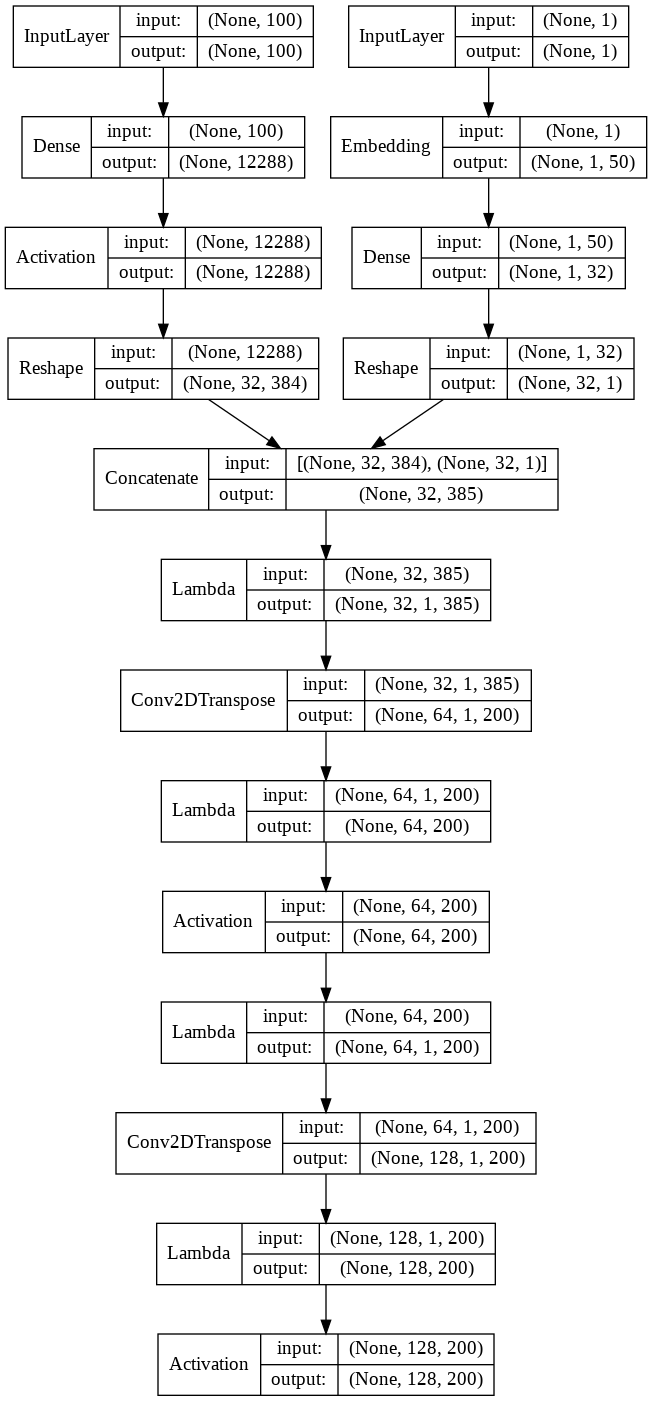

In [ ]:
# example of defining the generator model

# define the standalone generator model
def define_generator(latent_dim, n_classes=8):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 32
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	li = Reshape((32,1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 384 *32
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((32, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv1DTranspose(merge,200,5,2, padding='same', kernel_initializer=init)
	#gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	# upsample to 28x28
	gen = Conv1DTranspose(gen,200,5, 2, padding='same', kernel_initializer=init)
	out_layer = Activation('tanh')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='drive/My Drive/Colab Notebooks/generator_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

In [ ]:
# load images
def load_real_samples():
  """
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape, trainy.shape)
	"""
  X= trainX
  return [X, trainy]

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	texts, labels = dataset
	# choose random instances
	ix = randint(0, texts.shape[0], n_samples)
	# select images and labels
	X, labels = texts[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=8):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model,d_model, latent_dim, n_samples=100):
	"""
  # prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = '/content/drive/My Drive/Colab Notebooks/generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
 """
	# save the generator model
	#filename2 = '/content/drive/My Drive/Colab Notebooks/g_model_%04d.h5' % (step+1)
	#g_model.save(filename2)
  # save the discriminator model
	filename1 = '/content/drive/My Drive/Colab Notebooks/d_model_%04d.h5' % (step+1)
	d_model.save(filename1)
	print('>Saved: %s' % (filename1))

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
		# update discriminator model weights
		_,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		# generate 'fake' examples
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
		_,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		# prepare points in latent space as input for the generator
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		# summarize loss on this batch
		print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model,d_model, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Streaming output truncated to the last 5000 lines.
>112603, dr[0.225,0.815], df[0.454,0.188], g[1.754,0.401]
>112604, dr[0.526,0.318], df[0.330,0.184], g[2.321,0.275]
>112605, dr[0.184,0.281], df[0.498,0.289], g[2.813,0.322]
>112606, dr[0.313,0.133], df[0.663,0.377], g[3.051,0.336]
>112607, dr[1.006,0.367], df[0.085,0.268], g[2.201,0.302]
>112608, dr[0.926,0.202], df[0.472,0.425], g[3.463,0.278]
>112609, dr[0.722,0.119], df[0.775,0.683], g[2.060,0.240]
>112610, dr[0.388,0.488], df[0.572,0.287], g[2.252,0.325]
>112611, dr[0.540,0.616], df[0.516,0.219], g[2.079,0.444]
>112612, dr[0.288,0.401], df[0.389,0.338], g[2.049,0.385]
>112613, dr[0.149,0.343], df[0.141,0.190], g[2.111,0.437]
>112614, dr[0.145,0.037], df[0.350,0.518], g[2.871,0.208]
>112615, dr[0.486,0.113], df[0.245,0.260], g[3.214,0.313]
>112616, dr[0.378,0.145], df[0.238,0.226], g[2.287,0.345]
>112617, dr[0.300,0.181], df[1.204,0.530], g[1.804,0.247]
>112618, dr[1.578,0.401], df[0.197,0.343], g[2.939,0.417]
>112619, dr[0.912,0.3

In [ ]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = asarray([n_class for _ in range(n_samples)])
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n_examples):
	# plot images
	for i in range(n_examples):
		# define subplot
		pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
#g_model = load_model('/content/drive/My Drive/Colab Notebooks/g_model_117600.h5')
d_model = load_model('/content/drive/My Drive/Colab Notebooks/d_model_117600.h5')
"""
latent_dim = 100
n_examples = 100 # must be a square
n_class = 0 # sneaker
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate image

X  = g_model.predict([latent_points, labels])

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, n_examples)
"""
#g_model.summary()
d_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 64, 200)      0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 32, 180)      108180      input_9[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 32, 180)      0           conv1d_9[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 32, 180)      0           leaky_re_lu_9[0][0]              
____________________________________________________________________________________________

In [ ]:
model1 = Model(inputs= d_model.get_layer(index=0).output, outputs=d_model.get_layer(index=1).output)
print(model1.summary())
x=model1.predict(embed_X,verbose=1)
#np.array(x).shape

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 200)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 32, 180)           108180    
Total params: 108,180
Trainable params: 108,180
Non-trainable params: 0
_________________________________________________________________
None
91795/91795 [==============================] - 13s 142us/step


In [ ]:
x=np.reshape(x, (x.shape[0],-1))

In [ ]:
x.shape

(91795, 5760)

In [ ]:
pkl_file = open('drive/My Drive/Colab Notebooks/dataset/labels.pkl', 'rb')
y = pickle.load(pkl_file)
print(labels.shape)
pkl_file.close()

(91795,)


In [ ]:
from sklearn.model_selection import train_test_split
trainX, testX, trainy, testy = train_test_split(x, y, test_size=0.18)

In [ ]:
# define the keras model
model = Sequential()
model.add(Dense(1024, input_dim=6400, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
#model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='softmax'))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1024)              6554624   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_15 (Dense)             (None, 8)                

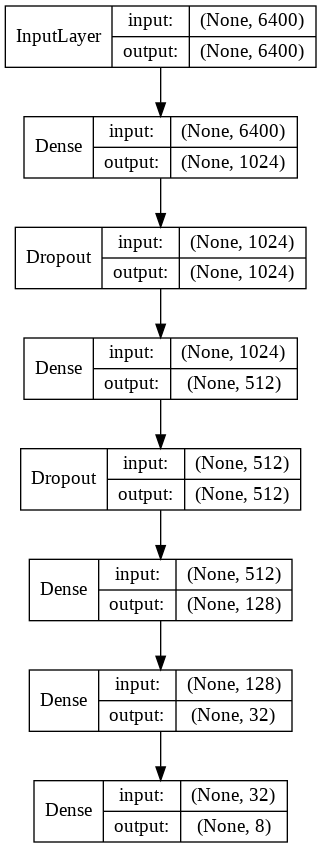

In [ ]:
#model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['acc'])
# summarize the model
print(model.summary())

plot_model(model, to_file='drive/My Drive/Colab Notebooks/classifier_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
history = model.fit(trainX, trainy, epochs=30,batch_size=256,shuffle=False, verbose=1,validation_split=0.1)

Train on 67743 samples, validate on 7528 samples
Epoch 1/30
67743/67743 [==============================] - 4s 57us/step - loss: 0.1760 - acc: 0.9591 - val_loss: 0.0936 - val_acc: 0.9818
Epoch 2/30
67743/67743 [==============================] - 3s 51us/step - loss: 0.1028 - acc: 0.9817 - val_loss: 0.0852 - val_acc: 0.9830
Epoch 3/30
67743/67743 [==============================] - 3s 51us/step - loss: 0.0989 - acc: 0.9824 - val_loss: 0.0938 - val_acc: 0.9814
Epoch 4/30
67743/67743 [==============================] - 3s 51us/step - loss: 0.0953 - acc: 0.9828 - val_loss: 0.0848 - val_acc: 0.9831
Epoch 5/30
67743/67743 [==============================] - 3s 51us/step - loss: 0.0954 - acc: 0.9827 - val_loss: 0.0901 - val_acc: 0.9825
Epoch 6/30
67743/67743 [==============================] - 3s 52us/step - loss: 0.0932 - acc: 0.9831 - val_loss: 0.0812 - val_acc: 0.9831
Epoch 7/30
67743/67743 [==============================] - 3s 51us/step - loss: 0.0902 - acc: 0.9838 - val_loss: 0.0883 - val_acc:

In [ ]:
results = model.evaluate(testX, testy)
print(results)

16524/16524 [==============================] - 1s 72us/step
[0.08327812255173966, 0.9840837717056274]
